In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Fixed random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [46]:
# Task 1

In [47]:
# Load dataset
column_names = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
data = pd.read_csv('wdbc.data', header=None, names=column_names)

# Extract features and labels
X = data.iloc[:, 2:].values
y_labels = data['Diagnosis'].values
# M=1 (malignant), B=0 (benign)
y = np.where(y_labels == 'M', 1, 0)

print(f"Dataset: {len(y)} samples, {X.shape[1]} features")
print(f"Class distribution: Benign={np.sum(y==0)}, Malignant={np.sum(y==1)}")

Dataset: 569 samples, 30 features
Class distribution: Benign=357, Malignant=212


In [48]:
# Split: 70% train, 10% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=y_temp)

print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")

Train: 398, Validation: 57, Test: 114


In [49]:
# Feature standardization (fit on train, transform all)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Train single logistic regression model
# Hyperparameters: penalty=l2, C=1.0, solver=lbfgs, max_iter=1000
model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train_scaled, y_train)
print("Q1 Model trained.")

Q1 Model trained.


In [51]:
# Evaluation function
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    prec_0 = precision_score(y, y_pred, pos_label=0)
    prec_1 = precision_score(y, y_pred, pos_label=1)
    avg_prec = (prec_0 + prec_1) / 2
    recall_1 = recall_score(y, y_pred, pos_label=1)
    
    print(f"\n{dataset_name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Average Precision: {avg_prec:.4f}")
    print(f"  Malignant Recall: {recall_1:.4f}")
    return acc, avg_prec, recall_1

# Evaluate all datasets
q1_train = evaluate_model(model, X_train_scaled, y_train, "Training Set")
q1_val = evaluate_model(model, X_val_scaled, y_val, "Validation Set")
q1_test = evaluate_model(model, X_test_scaled, y_test, "Test Set")


Training Set:
  Accuracy: 0.9849
  Average Precision: 0.9867
  Malignant Recall: 0.9664

Validation Set:
  Accuracy: 0.9825
  Average Precision: 0.9773
  Malignant Recall: 1.0000

Test Set:
  Accuracy: 0.9649
  Average Precision: 0.9672
  Malignant Recall: 0.9286


In [52]:
# Task 2

In [53]:
# Train 5 experts on disjoint subsets of training data
n_experts = 5
experts = []

skf = StratifiedKFold(n_splits=n_experts, shuffle=True, random_state=RANDOM_STATE)

print("Training 5 expert models on disjoint subsets:")
for i, (_, subset_idx) in enumerate(skf.split(X_train_scaled, y_train), start=1):
    X_subset = X_train_scaled[subset_idx]
    y_subset = y_train[subset_idx]
    
    print(f"  Expert {i}: {len(X_subset)} samples (B:{np.sum(y_subset==0)}, M:{np.sum(y_subset==1)})")
    
    expert = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
    expert.fit(X_subset, y_subset)
    experts.append(expert)

Training 5 expert models on disjoint subsets:
  Expert 1: 80 samples (B:50, M:30)
  Expert 2: 80 samples (B:50, M:30)
  Expert 3: 80 samples (B:50, M:30)
  Expert 4: 79 samples (B:50, M:29)
  Expert 5: 79 samples (B:49, M:30)


In [54]:
# Build gating labels using validation set
# For each sample: if expert j predicts correctly, it's a candidate
# Randomly select one correct expert; if none correct, random assignment
gating_labels = np.zeros(len(X_val_scaled), dtype=int)

for i in range(len(X_val_scaled)):
    x = X_val_scaled[i:i+1]
    y_true = y_val[i]
    
    preds = [expert.predict(x)[0] for expert in experts]
    correct = [j for j in range(n_experts) if preds[j] == y_true]
    
    if len(correct) == 0:
        gating_labels[i] = np.random.randint(0, n_experts)
    else:
        gating_labels[i] = np.random.choice(correct)

# Show label distribution
vals, cnts = np.unique(gating_labels, return_counts=True)
label_dist = {f"Expert {v+1}": c for v, c in zip(vals, cnts)}
print(f"Gating label distribution: {label_dist}")

Gating label distribution: {'Expert 1': np.int64(7), 'Expert 2': np.int64(11), 'Expert 3': np.int64(11), 'Expert 4': np.int64(16), 'Expert 5': np.int64(12)}


In [55]:
# Train gating network (multinomial logistic regression)
gating_net = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE, C=1.0)
gating_net.fit(X_val_scaled, gating_labels)
print(f"Gating network trained. Validation accuracy: {gating_net.score(X_val_scaled, gating_labels):.4f}")

Gating network trained. Validation accuracy: 0.5263


In [56]:
# Mixture of Experts inference algorithm
def predict_ensemble(X, experts, gating_net, threshold=0.5):
    n = X.shape[0]
    probs = np.zeros(n)
    
    for i in range(n):
        x = X[i:i+1]
        # gating weights
        w = gating_net.predict_proba(x)[0]
        # expert probs
        p = np.array([exp.predict_proba(x)[0, 1] for exp in experts])
        # weighted sum
        probs[i] = np.sum(w * p)
    
    preds = (probs >= threshold).astype(int)
    return preds, probs

In [57]:
# Evaluate ensemble
def evaluate_ensemble(X, y, experts, gating_net, dataset_name, threshold=0.5):
    y_pred, _ = predict_ensemble(X, experts, gating_net, threshold)
    acc = accuracy_score(y, y_pred)
    prec_0 = precision_score(y, y_pred, pos_label=0, zero_division=0)
    prec_1 = precision_score(y, y_pred, pos_label=1, zero_division=0)
    avg_prec = (prec_0 + prec_1) / 2
    recall_1 = recall_score(y, y_pred, pos_label=1)
    
    print(f"\n{dataset_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Malignant Recall: {recall_1:.4f}")
    return acc, avg_prec, recall_1

# Evaluate on all datasets
q2_train = evaluate_ensemble(X_train_scaled, y_train, experts, gating_net, "Training Set")
q2_val = evaluate_ensemble(X_val_scaled, y_val, experts, gating_net, "Validation Set")
q2_test = evaluate_ensemble(X_test_scaled, y_test, experts, gating_net, "Test Set")


Training Set:
Accuracy: 0.9673
Average Precision: 0.9684
Malignant Recall: 0.9396

Validation Set:
Accuracy: 1.0000
Average Precision: 1.0000
Malignant Recall: 1.0000

Test Set:
Accuracy: 0.9561
Average Precision: 0.9605
Malignant Recall: 0.9048


In [58]:
# Task 3

In [59]:
# Compare Q1 vs Q2 on test set
comparison = pd.DataFrame({
    "Model": ["Q1: Single Logistic", "Q2: Mixture of Experts"],
    "Accuracy": [q1_test[0], q2_test[0]],
    "Average Precision": [q1_test[1], q2_test[1]],
    "Malignant Recall": [q1_test[2], q2_test[2]]
})
print(comparison.to_string(index=False))

                 Model  Accuracy  Average Precision  Malignant Recall
   Q1: Single Logistic  0.964912           0.967230          0.928571
Q2: Mixture of Experts  0.956140           0.960513          0.904762


In [60]:
# Task 4

In [61]:
# Helper: train an ensemble with optional class_weight
def train_ensemble(X_train, y_train, X_val, y_val, class_weight=None, random_state=RANDOM_STATE):
    n_experts = 5
    skf = StratifiedKFold(n_splits=n_experts, shuffle=True, random_state=random_state)
    experts = []

    # Train 5 experts on different subsets
    for _, subset_idx in skf.split(X_train, y_train):
        X_sub = X_train[subset_idx]
        y_sub = y_train[subset_idx]

        expert = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=random_state, class_weight=class_weight)
        expert.fit(X_sub, y_sub)
        experts.append(expert)

    # Build gating labels on validation set
    n_val = len(X_val)
    gating_labels = np.zeros(n_val, dtype=int)

    for i in range(n_val):
        x = X_val[i:i+1]
        y_true = y_val[i]

        preds = [exp.predict(x)[0] for exp in experts]
        correct = [j for j in range(n_experts) if preds[j] == y_true]

        if len(correct) == 0:
            gating_labels[i] = np.random.randint(0, n_experts)
        else:
            gating_labels[i] = np.random.choice(correct)

    # Train softmax gating network
    gating_net = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=random_state, C=1.0)
    gating_net.fit(X_val, gating_labels)

    return experts, gating_net


# Inference with adjustable threshold
def predict_ensemble_threshold(X, experts, gating_net, threshold=0.5):
    n = X.shape[0]
    probs = np.zeros(n)

    for i in range(n):
        x = X[i:i+1]
        w = gating_net.predict_proba(x)[0]
        p = np.array([exp.predict_proba(x)[0, 1] for exp in experts])
        probs[i] = np.sum(w * p)

    preds = (probs >= threshold).astype(int)
    return preds, probs


def eval_with_threshold(X, y, experts, gating_net, threshold=0.5):
    y_pred, _ = predict_ensemble_threshold(X, experts, gating_net, threshold)

    acc = accuracy_score(y, y_pred)
    prec_0 = precision_score(y, y_pred, pos_label=0, zero_division=0)
    prec_1 = precision_score(y, y_pred, pos_label=1, zero_division=0)
    avg_prec = (prec_0 + prec_1) / 2
    recall_mal = recall_score(y, y_pred, pos_label=1)

    return {'accuracy': acc,'avg_precision': avg_prec,'recall_malignant': recall_mal}

In [62]:
# Experiment 0: Baseline (τ = 0.5, no class weights)
baseline_experts, baseline_gating = train_ensemble(X_train_scaled, y_train, X_val_scaled, y_val, class_weight=None)

baseline_val = eval_with_threshold(X_val_scaled, y_val, baseline_experts, baseline_gating)
baseline_test = eval_with_threshold(X_test_scaled, y_test, baseline_experts, baseline_gating)

print(f"Validation: Avg Prec = {baseline_val['avg_precision']:.4f}, " f"Recall(malignant) = {baseline_val['recall_malignant']:.4f}")
print(f"Test: Avg Prec = {baseline_test['avg_precision']:.4f}, "f"Recall(malignant) = {baseline_test['recall_malignant']:.4f}")

Validation: Avg Prec = 1.0000, Recall(malignant) = 1.0000
Test: Avg Prec = 0.9737, Recall(malignant) = 0.9048


In [63]:
# Experiment 1: Change decision threshold
print("\nExperiment 1: Threshold calibration")

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
threshold_results = []

print("Validation results for different thresholds:")
for t in thresholds:
    metrics = eval_with_threshold(X_val_scaled, y_val, baseline_experts, baseline_gating, t)
    threshold_results.append({
        'threshold': t,
        'avg_precision': metrics['avg_precision'],
        'recall_malignant': metrics['recall_malignant']
    })
    print(f"  threshold={t:.2f}: Avg Prec={metrics['avg_precision']:.4f}, " f"Recall={metrics['recall_malignant']:.4f}")

threshold_df = pd.DataFrame(threshold_results)

# Select best threshold (highest recall)
best_t_idx = threshold_df['recall_malignant'].idxmax()
best_threshold = threshold_df.loc[best_t_idx, 'threshold']

print(f"\nSelected threshold = {best_threshold}")
print(f"Validation at threshold: Avg Prec = {threshold_df.loc[best_t_idx, 'avg_precision']:.4f}, " f"Recall = {threshold_df.loc[best_t_idx, 'recall_malignant']:.4f}")

threshold_test = eval_with_threshold(X_test_scaled, y_test, baseline_experts, baseline_gating, best_threshold)
print(f"Test at threshold:Avg Prec = {threshold_test['avg_precision']:.4f}, " f"Recall = {threshold_test['recall_malignant']:.4f}")


Experiment 1: Threshold calibration
Validation results for different thresholds:
  threshold=0.20: Avg Prec=0.9200, Recall=1.0000
  threshold=0.25: Avg Prec=0.9565, Recall=1.0000
  threshold=0.30: Avg Prec=0.9565, Recall=1.0000
  threshold=0.35: Avg Prec=0.9773, Recall=1.0000
  threshold=0.40: Avg Prec=1.0000, Recall=1.0000
  threshold=0.45: Avg Prec=1.0000, Recall=1.0000
  threshold=0.50: Avg Prec=1.0000, Recall=1.0000
  threshold=0.55: Avg Prec=1.0000, Recall=1.0000
  threshold=0.60: Avg Prec=1.0000, Recall=1.0000

Selected threshold = 0.2
Validation at threshold: Avg Prec = 0.9200, Recall = 1.0000
Test at threshold:Avg Prec = 0.9468, Recall = 1.0000


In [64]:
# Experiment 2: Change malignant class weight in experts
print("\nExperiment 2: Class weight calibration")

mal_weights = [1.0, 2.0, 3.0, 5.0, 7.0]
weight_results = []

print("Validation results for different malignant class weights:")
for w in mal_weights:
    print(f"  Training experts with class_weight={{0: 1.0, 1: {w}}}")
    class_w = {0: 1.0, 1: w}

    experts_w, gating_w = train_ensemble(X_train_scaled, y_train, X_val_scaled, y_val, class_weight=class_w)

    metrics = eval_with_threshold(X_val_scaled, y_val, experts_w, gating_w, threshold=0.5)
    weight_results.append({
        'w_malignant': w,
        'avg_precision': metrics['avg_precision'],
        'recall_malignant': metrics['recall_malignant'],
        'experts': experts_w,
        'gating': gating_w
    })
    print(f"Val: Avg Prec={metrics['avg_precision']:.4f}, " f"Recall={metrics['recall_malignant']:.4f}")

# DataFrame for plotting (without model objects)
weight_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['experts', 'gating']} for r in weight_results])

# Select best weight (highest recall)
best_w_idx = weight_df['recall_malignant'].idxmax()
best_w = weight_results[best_w_idx]['w_malignant']
best_experts = weight_results[best_w_idx]['experts']
best_gating = weight_results[best_w_idx]['gating']

print(f"\nSelected malignant class weight w* = {best_w}")
print(f"Validation at w*: Avg Prec = {weight_df.loc[best_w_idx, 'avg_precision']:.4f}, " f"Recall = {weight_df.loc[best_w_idx, 'recall_malignant']:.4f}")

weight_test = eval_with_threshold(X_test_scaled, y_test, best_experts, best_gating, threshold=0.5)
print(f"Test at w*:Avg Prec = {weight_test['avg_precision']:.4f}, " f"Recall = {weight_test['recall_malignant']:.4f}")


Experiment 2: Class weight calibration
Validation results for different malignant class weights:
  Training experts with class_weight={0: 1.0, 1: 1.0}
Val: Avg Prec=1.0000, Recall=1.0000
  Training experts with class_weight={0: 1.0, 1: 2.0}
Val: Avg Prec=0.9865, Recall=0.9524
  Training experts with class_weight={0: 1.0, 1: 3.0}
Val: Avg Prec=0.9865, Recall=0.9524
  Training experts with class_weight={0: 1.0, 1: 5.0}
Val: Avg Prec=0.9773, Recall=1.0000
  Training experts with class_weight={0: 1.0, 1: 7.0}
Val: Avg Prec=0.9565, Recall=1.0000

Selected malignant class weight w* = 1.0
Validation at w*: Avg Prec = 1.0000, Recall = 1.0000
Test at w*:Avg Prec = 0.9800, Recall = 0.9286


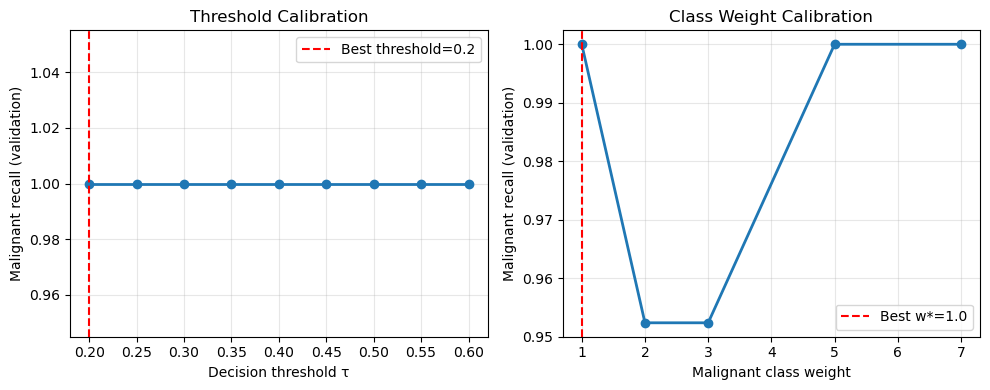

In [65]:
# Visualizations: threshold vs recall, weight vs recall
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: threshold vs malignant recall (validation set)
axes[0].plot(threshold_df['threshold'], threshold_df['recall_malignant'], 'o-', linewidth=2)
axes[0].axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold={best_threshold}')
axes[0].set_xlabel('Decision threshold τ')
axes[0].set_ylabel('Malignant recall (validation)')
axes[0].set_title('Threshold Calibration')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: class weight vs malignant recall (validation set)
axes[1].plot(weight_df['w_malignant'], weight_df['recall_malignant'], 'o-', linewidth=2)
axes[1].axvline(best_w, color='red', linestyle='--', label=f'Best w*={best_w}')
axes[1].set_xlabel('Malignant class weight')
axes[1].set_ylabel('Malignant recall (validation)')
axes[1].set_title('Class Weight Calibration')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('q4_calibration_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
# Final summary
print(f"Baseline (threshold = 0.5, w=1.0): Avg Prec={baseline_test['avg_precision']:.4f}, Recall={baseline_test['recall_malignant']:.4f}")
print(f"Best threshold (threshold={best_threshold}): Avg Prec={threshold_test['avg_precision']:.4f}, Recall={threshold_test['recall_malignant']:.4f}")
print(f"Best class weight (w={best_w}): Avg Prec={weight_test['avg_precision']:.4f}, Recall={weight_test['recall_malignant']:.4f}")

Baseline (threshold = 0.5, w=1.0): Avg Prec=0.9737, Recall=0.9048
Best threshold (threshold=0.2): Avg Prec=0.9468, Recall=1.0000
Best class weight (w=1.0): Avg Prec=0.9800, Recall=0.9286
